In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import StackingClassifier, VotingClassifier, StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import Adam
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector

# Reading the dataset
df1 = pd.read_csv('cleaned_data.dat', sep=' ')                                                         
df1.columns =['compactness', 'circularity', 'distance circularity', 'radius ratio', 'pr.axis aspect ratio', 'max length aspect ratio', 'scatter ratio', 'elongatedness', 'pr axis rectangularity', 'max length rectangularity', 'scaled variance MAJOR AXIS', 'scaled variance MINOR AXIS', 'scaled radious of gyration', 'skewness about major axis', 'skewness about minor axis', 'kurtosis about minor axis', 'kurtosis about major axis', 'hollows ratio', 'vehicle class']

# Naive Bayes data preprocessing
df_small = df1
df_small.corr(method='pearson')
# next i will log_transform skewed attributes
df_small['pr.axis aspect ratio log'] = np.log(df_small['pr.axis aspect ratio'])
#df_small['scatter ratio log'] = np.log(df_small['scatter ratio'])
#df_small['pr axis rectangularity log'] = np.log(df_small['pr axis rectangularity'])
df_small['scaled variance MAJOR AXIS log'] = np.log(df_small['scaled variance MAJOR AXIS'])
#df_small['scaled variance MINOR AXIS log'] = np.log(df_small['scaled variance MINOR AXIS'])
df_small['skewness about major axis log'] = np.log(df_small['skewness about major axis'])
## skewness about minor axis includes 0 values and it is not possible to log-transform, so i have hadded a very tiny number
df_small['skewness about minor axis log'] = np.log(df_small['skewness about minor axis']+0.000001)

# Neural Network data preprocessing
dataset = df1
y = dataset['vehicle class'].values
encoder = LabelEncoder()
y1 = encoder.fit_transform(y)
y1
Y = pd.get_dummies(y1).values

# New column order so that we can specify the features in stacking for each classifiers
col = ['compactness','distance circularity', 'radius ratio', 'pr.axis aspect ratio', 'max length aspect ratio', 'elongatedness', 'max length rectangularity', 'scaled variance MAJOR AXIS', 
       'scaled radious of gyration', 'skewness about major axis', 'skewness about minor axis', 'kurtosis about minor axis', 'kurtosis about major axis', 'hollows ratio', 
       'circularity', 'scatter ratio', 'pr axis rectangularity',  'scaled variance MINOR AXIS', 
       'pr.axis aspect ratio log', 'scaled variance MAJOR AXIS log', 'skewness about major axis log', 'skewness about minor axis log', 'vehicle class']

# A dataframe with all features including the original ones and log ones
df1 = df_small[col]
dfall = df1
dfall

,compactness,distance circularity,radius ratio,pr.axis aspect ratio,max length aspect ratio,elongatedness,max length rectangularity,scaled variance MAJOR AXIS,scaled radious of gyration,skewness about major axis,...,hollows ratio,circularity,scatter ratio,pr axis rectangularity,scaled variance MINOR AXIS,pr.axis aspect ratio log,scaled variance MAJOR AXIS log,skewness about major axis log,skewness about minor axis log,vehicle class
0,91,84,141,57,9,45,143,170,158,72,...,199,41,149,19,330,4.043051,5.135798,4.276666,2.197225e+00,van
1,104,106,209,66,10,32,158,223,220,73,...,196,50,207,23,635,4.189655,5.407172,4.290459,2.639057e+00,saab
2,93,82,159,63,9,46,143,160,127,63,...,207,41,144,19,309,4.143135,5.075174,4.143135,1.791760e+00,van
3,107,106,172,50,6,26,169,280,264,85,...,183,57,255,28,957,3.912023,5.634790,4.442651,1.609438e+00,bus
4,97,73,173,65,6,42,143,176,172,66,...,204,43,153,19,361,4.174387,5.170484,4.189655,2.564949e+00,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,93,87,183,64,8,40,134,200,149,72,...,195,39,169,20,422,4.158883,5.298317,4.276666,1.945910e+00,saab
809,89,84,163,66,11,43,159,173,176,72,...,197,46,159,20,368,4.189655,5.153292,4.276666,9.999995e-07,van
810,106,101,222,67,12,30,173,228,200,70,...,201,54,222,25,721,4.204693,5.429346,4.248495,1.098613e+00,saab
811,86,78,146,58,7,50,124,155,148,66,...,195,36,135,18,270,4.060443,5.043425,4.189655,-1.381551e+01,saab


In [2]:
# Split the data into features and classification column
x = df1.drop('vehicle class', axis=1)
y = df1['vehicle class'].copy()

x.shape, y.shape, Y.shape

((813, 22), (813,), (813, 4))

In [3]:
# Split data for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Reserve 20% samples for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((520, 22), (520,), (163, 22), (163,), (130, 22), (130,))

Stacking - decision tree, knn, naive bayes, neural network

In [4]:
# A function to select columns for fitting, before using the sklearn pipeline
def col_selection(x_set, columns):
    return x_set.iloc[:, columns]

# Training set columns selection
X_train_knn_dt_nn = col_selection(x_train, list(range(0, 18)))
X_train_gnb = col_selection(x_train, list(range(0, 14)) + [18] + [19] + [20] + [21])

# Testing set columns selection
X_test_knn_dt_nn = col_selection(x_test, list(range(0, 18)))
X_test_gnb = col_selection(x_test, list(range(0, 14)) + [18] + [19] + [20] + [21])

# Validation set columns selection
X_val_knn_dt = col_selection(x_val, list(range(0, 18)))
X_val_gnb = col_selection(x_val, list(range(0, 14)) + [18] + [19] + [20] + [21])

# Encode target variable from categories to int for the classifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Convert target variable to one-hot encoding for neural network
y_train_onehot = np_utils.to_categorical(y_train_encoded)
y_test_onehot = np_utils.to_categorical(y_test_encoded)
y_val_onehot = np_utils.to_categorical(y_val_encoded)

# A function to create a classifier for neural network, since keras classifier cannot be directly used in stackingCVclassifier
def create_nn_model():
    nn = Sequential([
        Dense(64, activation='relu', input_shape=(18,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
    nn.compile(Adam(learning_rate=0.001), 'categorical_crossentropy', metrics=['accuracy'])
    return nn

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=50, 
    min_delta=0.001, 
    mode='max')

# Defining classifiers
knn = KNeighborsClassifier(5)
dt = DecisionTreeClassifier()
gnb = GaussianNB()
nn = KerasClassifier(build_fn=create_nn_model, epochs=500, batch_size=8, verbose=0)
nn._estimator_type = "classifier"

# Training classifiers
knn.fit(X_train_knn_dt_nn, y_train_encoded)
dt.fit(X_train_knn_dt_nn, y_train_encoded)
gnb.fit(X_train_gnb, y_train_encoded)
nn.fit(X_train_knn_dt_nn, y_train_onehot, validation_data=(X_val_knn_dt, y_val_onehot), callbacks=[early_stopping])

# Use column selector to select the processing columns, and then make them into pipelines for the stacking classifier
pipeline1 = make_pipeline(ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)), knn)
pipeline2 = make_pipeline(ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)), dt)
pipeline3 = make_pipeline(ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21)), gnb)
pipeline4 = make_pipeline(ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17)), nn)

# Define the StackingCVClassifier with Logistic Regression as the meta-classifier, use_probas=True 
stacking_classifier = StackingCVClassifier(classifiers=[pipeline1, pipeline2, pipeline3, pipeline4], meta_classifier=LogisticRegression(), use_probas=True, cv=5)

# Train the stacking classifier
stacking_classifier.fit(x_train, y_train_encoded)

C:\Users\james\AppData\Local\Temp\ipykernel_24752\3304582514.py:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn = KerasClassifier(build_fn=create_nn_model, epochs=500, batch_size=8, verbose=0)


4/4 [==============================] - 0s 3ms/step


StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 1, 2,
                                                                        3, 4, 5,
                                                                        6, 7, 8,
                                                                        9, 10,
                                                                        11, 12,
                                                                        13, 14,
                                                                        15, 16,
                                                                        17))),
                                                  ('kneighborsclassifier',
                                                   KNeighborsClassifier())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(co

In [5]:
# Testing
y_pred_encoded = stacking_classifier.predict(x_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
accuracy = accuracy_score(y_test, y_pred)

# Validation
y_pre_val_encoded = stacking_classifier.predict(x_val)
y_pre = label_encoder.inverse_transform(y_pre_val_encoded)
accuracy1 = accuracy_score(y_val, y_pre)

# Precision
precision_val = precision_score(y_val, y_pre, average='weighted')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification report
report = classification_report(y_test, y_pred)

print(f"Testing Set accuracy: {accuracy}")
print(f"Validation Set accuracy: {accuracy1}")
print(f"Precision: {precision_val}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

5/5 [==============================] - 0s 2ms/step
Testing Set accuracy: 0.7852760736196319
Validation Set accuracy: 0.7153846153846154
Precision: 0.7188181188181187
Classification Report:
              precision    recall  f1-score   support

         bus       0.98      1.00      0.99        40
        opel       0.67      0.58      0.62        45
        saab       0.53      0.60      0.56        35
         van       0.95      0.95      0.95        43

    accuracy                           0.79       163
   macro avg       0.78      0.78      0.78       163
weighted avg       0.79      0.79      0.79       163

Confusion Matrix:
[[40  0  0  0]
 [ 0 26 18  1]
 [ 1 12 21  1]
 [ 0  1  1 41]]


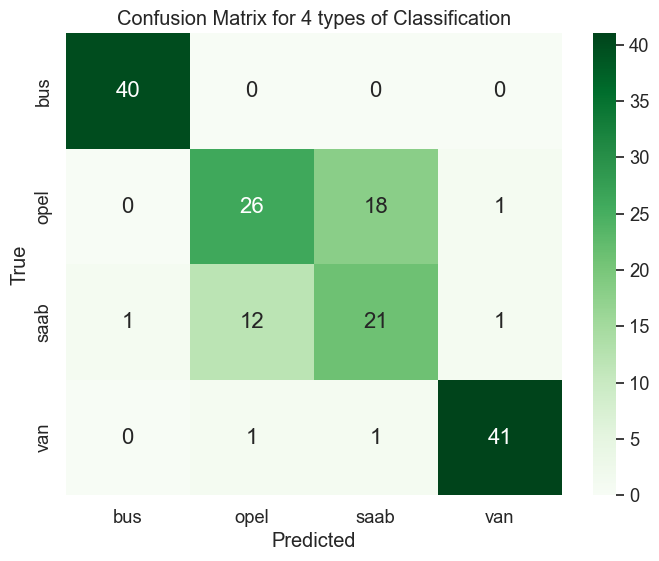

In [6]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4 types of Classification')
plt.show()

In [7]:
# Exporting the ensemble model to pickle
import pickle

with open('model_ensemble.pickle', 'wb') as file:
    pickle.dump(stacking_classifier, file)

INFO:tensorflow:Assets written to: ram://4e9bce72-9aea-490c-b5cd-063346da8fe5/assets
INFO:tensorflow:Assets written to: ram://349a4a51-663b-48f8-acb5-ef60a7ee92a0/assets
